# **Robert's Cross**

**Required Reading/Viewing:**

1. [Roberts, Lawrence G. Machine perception of three-dimensional solids. Diss. Massachusetts Institute of Technology, 1963." **Only Need to Read Abstact and Pages 25-27**.](https://dspace.mit.edu/bitstream/handle/1721.1/11589/33959125-MIT.pdf?sequence=2)

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

In [2]:
from IPython.core.display import display, HTML
display(HTML(s"<style>.container { width:90% !important; }</style>"))

In [3]:
#(Optional) Download data + videos if you don't have them.
import os, sys
sys.path.append('..')
from util.get_and_unpack import get_and_unpack

if not os.path.isdir('../data/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/data/data.zip'
    get_and_unpack(url, location='..')
    
if not os.path.isdir('../videos/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/videos.zip'
    get_and_unpack(url, location='..')   

![](../videos/brick_ball_cylinder.gif)

# How can we extract meaningful information from images like these?

- Let's borrow some great early ideas from the work of MIT graduate student **Lawrence Roberts**. 

![](../graphics/roberts_thesis-01.png)

- Robert's phD thesis delt with constructing three dimensional models of solids from single photographs, these models could then be rotated and the solids could be viewed from any perspective. 
- Interestingly, Roberts next job was the ["...manager and principal architect of the precursor to the Internet."](https://www.ibiblio.org/pioneers/roberts.html)
- Robert's approach begins with extracting a "line drawing" or finding the edges of the solid. 
- We'll have a closer look at Robert's approach, but we first need some data!



In [1]:
#ipython magic numpy and matplotlib import function
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load image
im = imread('../data/easy/brick/brick_1.jpg')

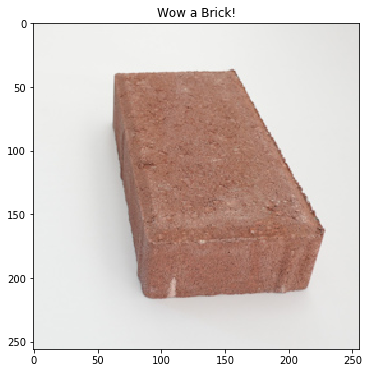

In [3]:
#Display Image
fig = figure(0, (6,6))
imshow(im); title('Wow a Brick!');

In [4]:
im.shape

(256, 256, 3)

In [5]:
im.dtype

dtype('uint8')

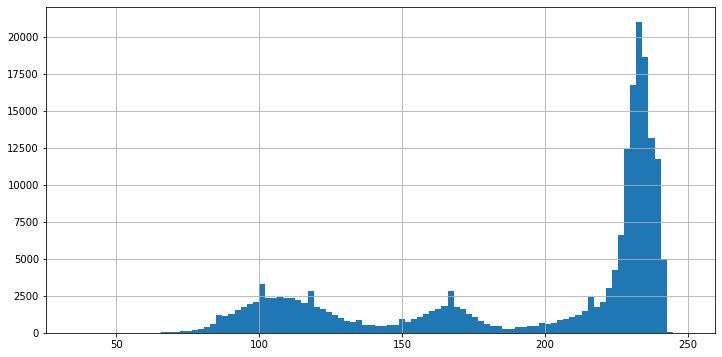

In [6]:
#It's generally a good idea to get a feel for the distribution of our data
fig = figure(0, (12,6))
hist(im.ravel(), 100); grid(1)

Now, before we dive too deep into Robert's Equations, let's make two modifications to our image. 

**1. Scaling** Our image is currently scaled between 0 and 255. There are very good reasons for this - many images, including ours, are stored as 8 bit unsigned integers - this saves space, as we only need 8 bits of storage for each pixel. However, often (but not always), it will be easier to work with our images if we first scale them between 0 and 1. Note that this scaling will require us to change to a float data type.

**2. Grayscale** Our image is currently color, but the images Roberts would have worked with were grayscale, and further it's often useful to convert images to grayscale to simplify processing - we'll do this quite often. In fact, we're going to do it so often that we should write a method for it.

In [7]:
#scale image between 0 and 1
im_scaled = im/255

In [8]:
im_scaled.dtype

dtype('float64')

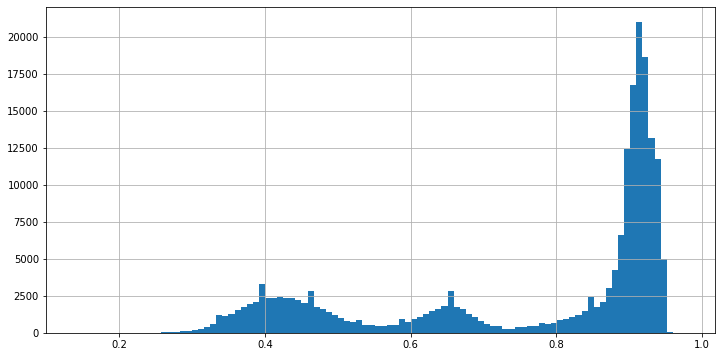

In [9]:
#It's generally a good idea to get a feel for the distribution of data
fig = figure(0, (12,6))
hist(im_scaled.ravel(), 100); grid(1)

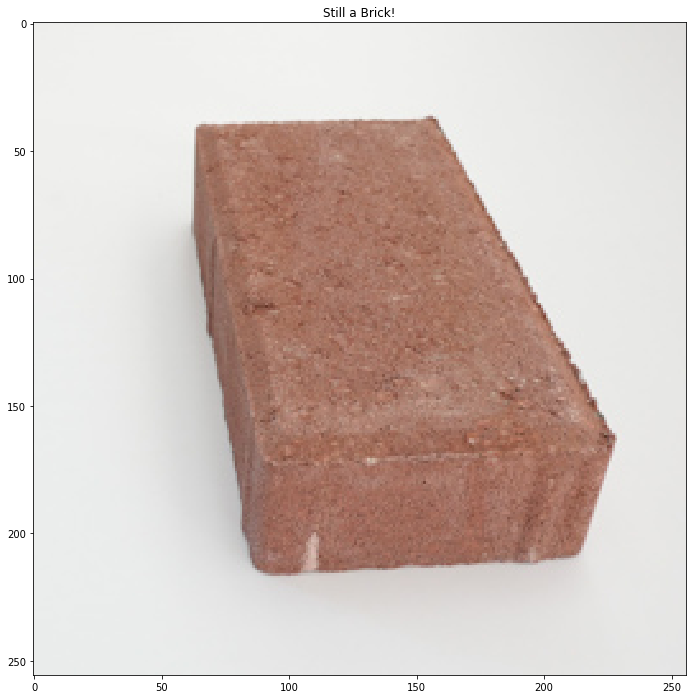

In [10]:
#Does matplotlib's imshow work the same way with our scaled data?
fig = figure(0, (12,12))
imshow(im_scaled); title('Still a Brick!'); 

We'll be doing this fairly often, so let's go ahead and write a method to convert floating point images to grayscale:

In [11]:
def convert_to_grayscale(im):
    '''
    Convert color image to grayscale.
    Args: im = (nxmx3) floating point color image scaled between 0 and 1
    Returns: (nxm) floating point grayscale image scaled between 0 and 1
    '''
    return np.mean(im, axis = 2)

In [12]:
#We'll use Robert's notation, and call our grayscale image x
x = convert_to_grayscale(im_scaled)

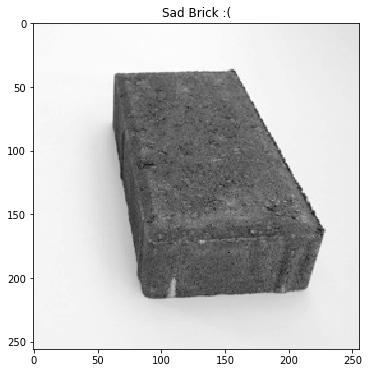

In [19]:
fig = figure(0, (6,6))
imshow(x, cmap = 'gray'); title('Sad Brick :(');

In [20]:
x.shape

(256, 256)

## **Ok, so how did Roberts find edges way back in 1963?**

___

![](../graphics/roberts_equations.png)

___

Roberts first took the square root of the intensity values ("Gamma correcting the image") to take into account the non-linear human perception of light intensities. It turns out that, unlike Robert's images, most images we'll be dealing with in the course have already been gamma corrected, so we don't have to worry about his first equation $y_{i, j} = \sqrt{x_{i, j}}$. In case you're interested in why we would Gamma correct and image check out this [nice video on gamma from MinutePhysics](https://www.youtube.com/watch?v=LKnqECcg6Gw).

In [21]:
# We don't need to take the square root, since gamma correction has already been
# applied to our image:
y = x

To extract the edges of the solid, Roberts then used a **"Local differential operator"**:

![](../graphics/spacer_small.png)

![](graphics/spacer_small.png)

$$
z_{i, j} = \sqrt{(y_{i, j} - y_{i+1, j+1})^2 + (y_{i+1, j} - y_{i, j+1})^2}
$$

![](../graphics/spacer_small.png)

# **Now, what's going on here?**

- Before we dive in, please take a moment and stare this equation down. 
- $y$ is our image, and according to Roberts, $z_{i, j}$ is the computed derivative value, and $i, j$ are the coordintes in the two dimensions of our image.
- Any intuition to be gained here? If you were to visualize this operation, what would it look like?

___

![](../graphics/roberts_cross-01.png)

- Here's one way to visualize Robert's "Local differential operator."
- We can imagine a small 2x2 matrix or kernel sliding across our image.
    - Within that kernel, the local pixel intensity values are sampled, we take the difference of pixels that are **across** from each other, square these values and add them together.
    - Today we call this operation, perhaps not surprisingly, [**Robert's cross**](https://en.wikipedia.org/wiki/Roberts_cross). 
- Now, let's try to pick up some intuition - when would we expect Robert's Cross to return an especially large or small value? 

![](../graphics/spacer_small.png)

___

![](../graphics/question_one-01.png)

___


- Which patch **minimizes** the value of Robert's Cross?
- Are there any other types of image patches that maximize the value of Robert's Cross?

![](../graphics/spacer_small.png)

![](graphics/spacer_small.png)

Yes! There are four image patches that will maximize Robert's Cross:

![](../graphics/roberts_cross_maximizers-01.png)

- As we can see, the image patches that maximize Robert's cross look like edges!
- This is the big idea here. Image patches contain edges should correspond to large values of Robert's cross. 
- The word "differential" may trigger some thoughts of differential equations or calculus. The central idea here is the same, we're looking to compute the 2 dimensional rate-of-spatial-change or derivative of our images. The big difference here is that since our data is discrete, we don't have formal definition of the derivate as we do in calculus class. Here Roberts is relying on an educated guess and some trial and error - a pretty common approach in computer vision.
- Ok, enough intuition, let's see Robert's Cross in action, and then code it up. 

## Robert's Cross in Action

![](../videos/roberts_cross_intuition.gif)

- Now that we have some intuition for Robert's Cross in action - how do we code it up? 
- We need to apply Roberts cross to **every 2x2 image patch in our image!**
- One way to acheive this to iterate through the rows and columns of our image. 

In [22]:
#How many patches to we need to compute Robert's Cross for?
x.shape

(256, 256)

---

![](../graphics/question_two-01.png)

---

- What does this answer say about the dimension of the output image of our Robert's Cross operation?
- We have to do a pretty large number of computations for a single, relatively small image, and we're implementing a 50 year old algorithm!
- Computational efficiency will be a big theme in this course, progress in computer vision has been and remains deeply connected with **computing power** and **algorithmic efficiency.**
- Alright, let's implement Robert's Cross: 

$$
z_{i, j} = \sqrt{(y_{i, j} - y_{i+1, j+1})^2 + (y_{i+1, j} - y_{i, j+1})^2}
$$

In [24]:
def roberts_cross(x):
    '''Compute Robert's Cross of input image x.
       Args: x (nxm) grayscale floating point image
       Returns: (n-1) x (m-1) edge image.'''
    
    #Our output will image will be one pixel smaller than our image
    edges = np.zeros((x.shape[0]-1,x.shape[1]-1)) 

    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            #Grab Appropriate (2x2) image patch
            image_patch = x[i:i+2, j:j+2]
            # Compute Robert's Cross for image patch
            edges[i, j] = np.sqrt((image_patch[0,0] - image_patch[1, 1])**2 + 
                                   (image_patch[1, 0] - image_patch[0, 1])**2)
            
    return edges

In [25]:
edges = roberts_cross(x)

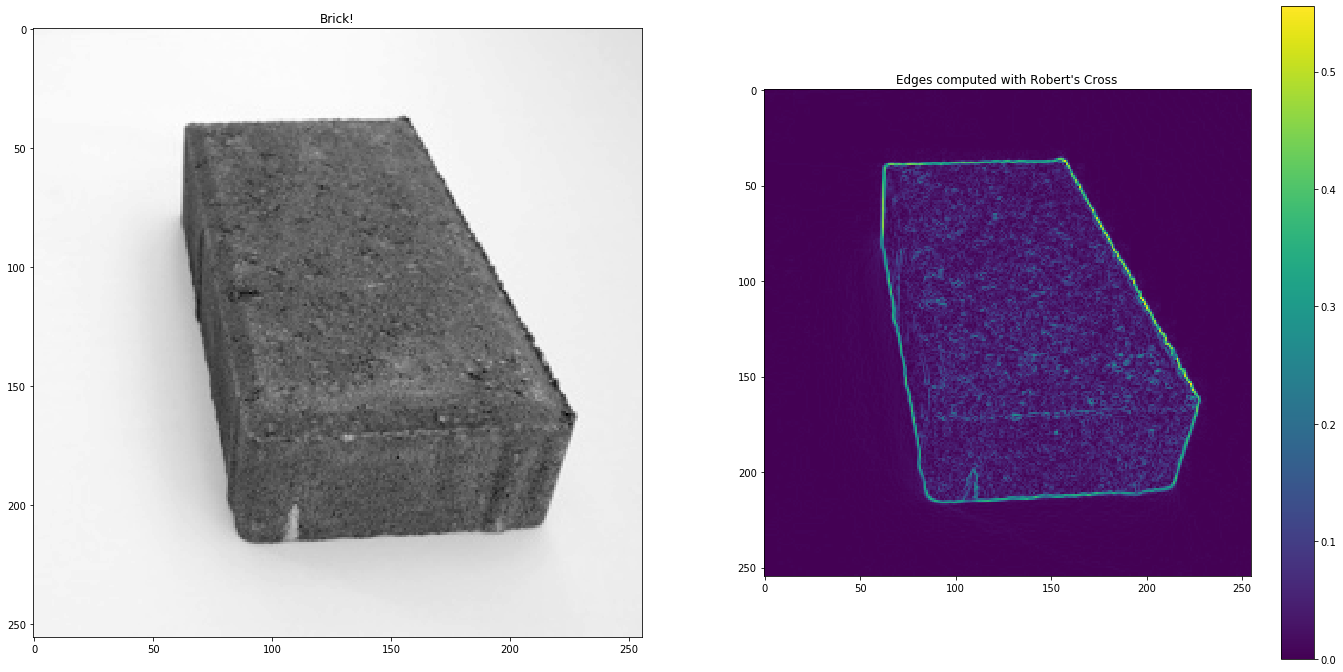

In [26]:
fig = figure(0, (24,12))
fig.add_subplot(1,2,1)
imshow(x, cmap = 'gray')
title('Brick!')

fig.add_subplot(1,2,2)
imshow(edges)
colorbar()
title("Edges computed with Robert's Cross");

- **Boom!** Look at those edges! We've made some real progress in computer vision :)
- Now, we're of course just getting started - Robert's work wasn't just about finding edges, but determining the full 3d shapes represented in images. 
- And for us, trying to find solutions the original MIT summer project (identifying bricks, balls, and cylinders in images), edges may be helpful, but we certainly aren't done. 
- In fact, we've really just begun, here's Robert's a little later in his paper:

> "It is no simple chore to obtain a list of lines and their end points from a half-million-bit array of data. A simple procedure might be to choose a clip level and start tracing out lines which correspond to a string of adjacent cells in the raster, all of whose values are above the clip level. **The hopelessness of this procedure is easily seen when one looks are typical pictures and considers them as a three-dimensional surface where the z values are used as the height."**

![](../videos/roberts_world_1.gif)

> *"The hopelessness of this procedure is easily seen when one looks are typical pictures and considers them as a three-dimensional surface where the z values are used as the height."*

<center> (Height of bars corresponds to edge intensity computed using Robert's Cross) </center>

![](../videos/roberts_world_2.gif)

> "Even a very clean input picture when viewed in this way looks like a bumpy, hilly landscape, with a broken-down stone wall representing the lines, and where some hills are higher than the top of other stone walls. If we imagine the clip level as a flood over this landscape, there is no water level which covers all the hills and yet does submerge the stone walls."

# Computer Vision is **Hard**

Let's look at one final quote from Roberts: 

> "The procedure I have developed for finding the lines from differential pictures makes mistakes in complex pictures and is a complex special-purpose program demonstrating very few general concepts."

- This is a big theme in computer vision. 
- Unlike other sciences like Newtonian Physics, that have clear unifying principles, we don't really see this yet in computer vision (although deep learning has made things more unified over the last few years).
- As you'll likeley see in this module's programming challenge, "one-off" or "special-purpose" algorithms are sometimes the best we can do. 
- Now, this quote *is* over 50 years old, and as you'll see in the course we have made significant progress since then, but in my opinion computer vision remains more a collection of problems + techniques than a single unified field. 
- I think an interesting question here is: **Is the fragmented nature of computer vision just a reflection of the nature of the problems we're trying to solve, or have we just not found the unifying princles yet? :).**

![](../graphics/spacer_small.png)

## Problems?


So we now have some understanding of how Robert's Cross works and some code to implement it. And now the not so great news: **Pretty much no one uses Robert's Cross today.**
- "Then why the heck did you make us learn this, Stephen?"
- Good Question! We aren't quite done with edge detection yet, and really understanding where Robert's Cross fails will help build your computer vision intuition, and improve your understanding of more sophisticated edge detectors.
- So, why isn't Roberts Cross used today?

# ** What are some potential problems with Robert's Cross? **

___

![](../graphics/roberts_equations.png)

___

![](graphics/spacer_small.png)

## **1. Noisy**

As Robert's points out, and as we see here, our edge images are quite noisy!

![](../videos/roberts_world_3.gif)

## 2. Anisotropic

![](../graphics/anisotropic_examples-01.png)

## **3. Slow**

We've implemented Robert's Cross using two python for loops to manually move our kernel across the image. This is a super slow way to do this. This becomes painfully obvious on large images:

In [20]:
im = imread('../graphics/full_size_brick.jpg')

In [21]:
im.shape

(3456, 4608, 3)

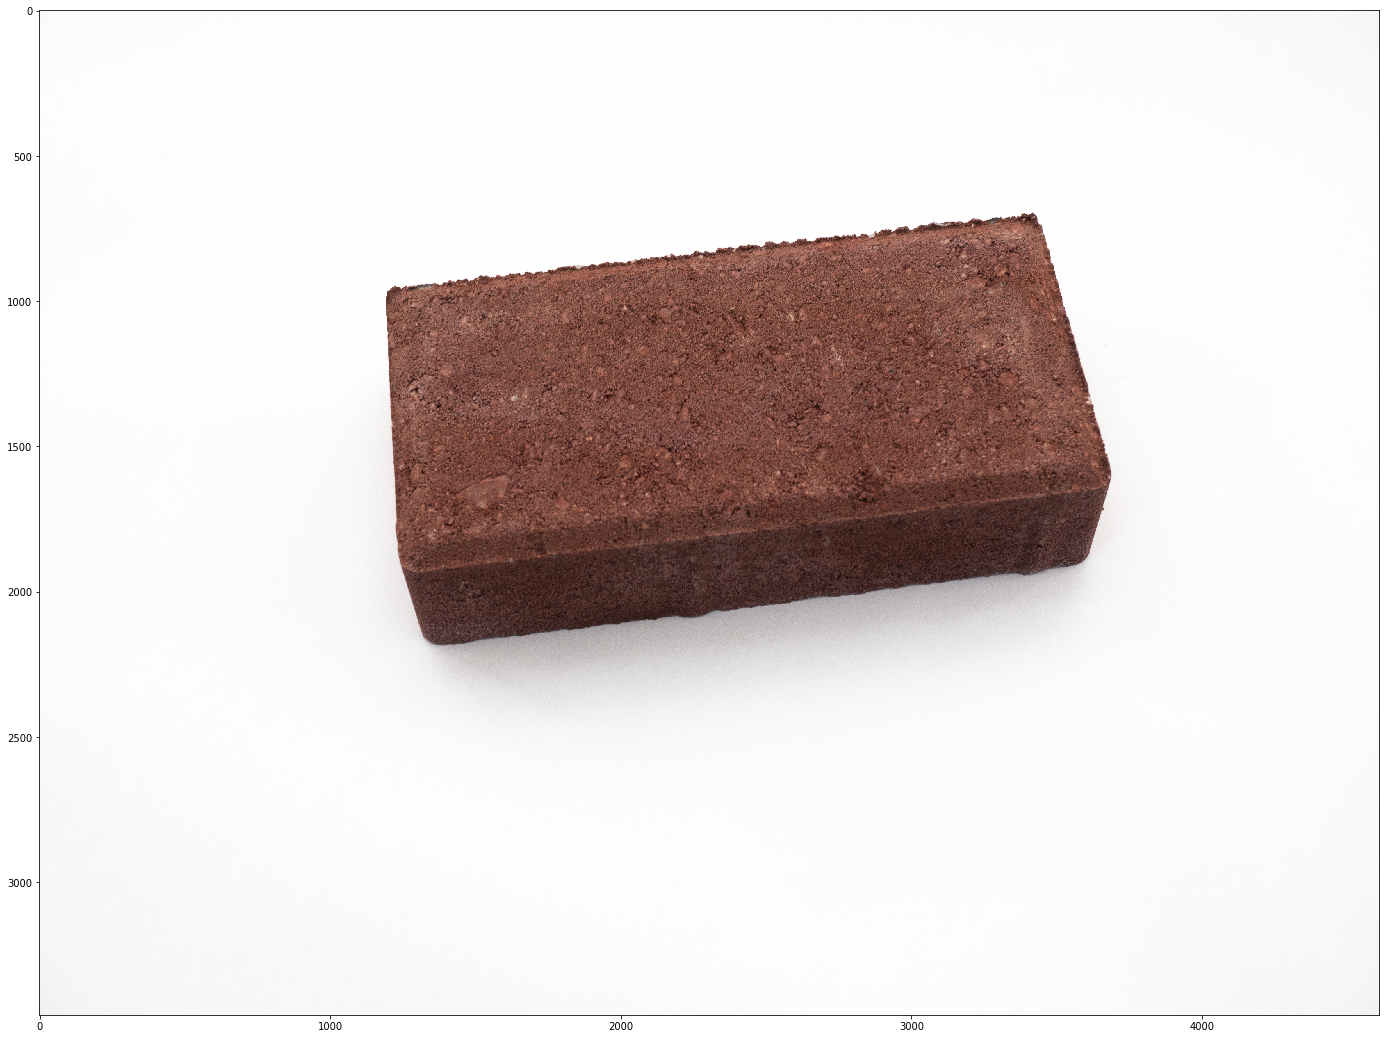

In [22]:
fig = figure(0, (24, 20))
imshow(im)

In [23]:
#Scale between one and zero and convert to gray scale
x = convert_to_grayscale(im/255.)

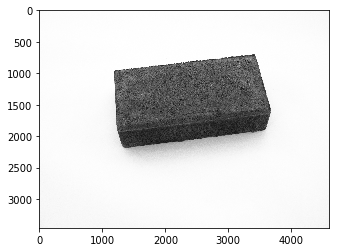

In [24]:
imshow(x, cmap = 'gray')

In [25]:
from tqdm import tqdm #A great way to time for loops

edges = np.zeros((x.shape[0]-1, x.shape[1]-1)) #Our output will image will be one pixel smaller than our image

for i in tqdm(range(x.shape[0]-1)):
    for j in range(x.shape[1]-1):
        #Grab Appropriate (2x2) image patch
        image_patch = x[i:i+2, j:j+2]
        # Compute Robert's Cross for image patch
        edges[i, j] = np.sqrt((image_patch[0,0] - image_patch[1, 1])**2 + 
                               (image_patch[1, 0] - image_patch[0, 1])**2)


100%|██████████| 3455/3455 [01:10<00:00, 49.05it/s]


- On my MacBook, this takes 49 seconds! 
- By the end of the course, we'll see how to speed up operations like many orders of magnitude faster on a GPU.
- Before we get anywhere near a GPU though, there's lots of smart stuff we can do to make operations like this waaaaay faster.

## **4. No Direction**

As we've implemented Robert's Cross here, we only learn about the **magnitude** of our esimate of the image intensity derivative, not its **direction.** Direction information could prove quite helpful. 

![](../graphics/spacer_small.png)

# **4 Problems with Robert's Cross**

1. **Noisy.** 
2. **Anisotropic** - doesn't respond as strongly to slanted edges. 
3. **Slow** as we've implemented it here.
4. **No Direction** as we've implemented Robert's Cross here, we only learn about the **magnitude** of our esimate of the image intensity derivative, not its **direction.** 

In our next lecture, we'll introduce a better edge detector, and make improvements in these 4 areas. But in the mean time - I want you to give this some real thought. If you were a computer vision researcher in the 1960s - maybe even part of the MIT summer project - what would you do?

![](../graphics/spacer_small.png)

# **How would you improve on Robert's Cross?**

![](../graphics/spacer_small.png)

Finally, if you had any trouble following the python presented here, this module is a good chance develop your python skills. A good starting exercise is implementing Robert's cross yourself in python. 